<h1>TD3 : Let's play with faces</h1>  
Part 2 - Celebrity look alike(find celebrity)

S. Delprat, INSA Hauts-de-France    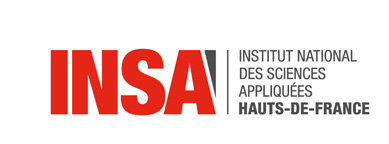


In [ ]:
# Import and install inception-resnet-v1 files
import os
import gdown
import zipfile
extractFolder='/content/'
if os.path.isdir(os.path.join(extractFolder,"InceptionResnetV1"))==0:
  file_id = "xxxxxx file id xxxxxxx"  # Replace this with your file's ID
  gdown.download(f"https://drive.google.com/uc?id={file_id}")

  with zipfile.ZipFile("InceptionResnetV1.zip", 'r') as zip_ref:
    zip_ref.extractall(extractFolder)


Mount google drive and define the binary file that contains the embedding vector

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
binaryEmbeddingFile='/content/gdrive/MyDrive/embeddingCelebrity.bin'

In [ ]:
# Import IMDB Head dataset
extractFolder='/content/'
baseFolder=os.path.join(extractFolder,'IMDB_Head_Aligned')
if os.path.isdir(baseFolder)==0:
  file_id = "xxxxxx file id xxxxxxx"  # Replace this with your file's ID
  gdown.download(f"https://drive.google.com/uc?id={file_id}")

  print('Extractinbg the dataset')
  with zipfile.ZipFile("IMDB_Head_Aligned.zip", 'r') as zip_ref:
    zip_ref.extractall(extractFolder)

In [ ]:
!pip install torchinfo
!pip install facenet-pytorch
import torch
import shutil
import torchvision
import seaborn as sns
from   sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import math
from glob import glob
from PIL import Image
import random
from torchinfo import summary
import numpy as np
from IPython.display import FileLink
import pandas as pd
from datetime import datetime
import os
from torchvision.transforms import v2
import pickle
from facenet_pytorch import MTCNN

Configuration of the hyperparameters

In [ ]:
maxImgsTrain,maxImgsValid,maxImgsTest=None,None,None
batchSize=128
H,W = 160,160        # image height & width
dataFolder   = baseFolder
embeddingFile =  'embeddingCelebrity.bin'

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [ ]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())


else:
  print('cuda is not available')
  device='cpu'

# 1) Load a pretrained model and prepare it for embedding extraction
Here we are going to use an Inception-Resnet-V1 model trained on the VGG Face2 dataset (the model has been generated using code from the <a href="https://github.com/timesler/facenet-pytorch">original repo</a>).  
This model requires the image to be scaled in the [-1,1] range. It is suggested to use the following transform: <code>modeltransforms=v2.Lambda(lambda x:x*2-1)</code>

The goal of this section is to load the model and replace all the layers contained in the classification head by identity.
The resulting model is denoted as backbone



*Q1.* Load the original model  
Store the model in the <code>backbone</code> variable

In [ ]:
Your code here to load the backbone

*Q2.* Replace the classification head by identity layers  

From the previous list, look at all the layers name (between parenthesis) that belongs to the classification head. Overwrite them by a <code>torch.nn.Identity layer</code>.  
As a result, the network will now output the embeding vector computed by the convolution part

In [ ]:
Your code here

Display the model summary and check that the classification head has been removed. Also take note of the shape of the produced data

# 2) Load and process the querry image

This function load an image given its file name

In [ ]:
def loadImage(fileName):
  img = Image.open(fileName)
  img2 = v2.PILToTensor()(img)
  return img2

*Q3.* Copy an image to your google drive.  
Browse to this image and copy the image path

In [ ]:
queryImagePath="/content/gdrive/MyDrive/xxxxxx.jpg"


*Q4.* Load and display the query image   
Store the image into a variable <code>queryImg</code>

In [ ]:
 your code here

*Q5.* Copy the faceCropping function from the previous exercices (age prediction)

In [ ]:
Copy the code here

Define a mtcnn object to detect faces  

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

*Q6.* add a batch dimension to the reference image <code>queryImg</code>using <code>unsqueeze</code> in order to make the image size compatible with the existing <code>faceCropping</code> function that requires tensor with shape batch x 3 x width x height .  

In [ ]:
Your code here

*Q7.* Apply the face cropping function to that batch and display the result shape

In [ ]:
croppedQueryImg,nLost = Your code here

*Q8.* Compute the embedding vector for this batch using the backbone  
Store the embedding vector into <code>queryEmbeddingBatch</code>

In [ ]:
Your code here

# 3) Search for the celebrity lookalike

At this point of the program, we have a variable <code>refEmbeddingBatch</code> of size batch(1) x 1792 (embedding vect size) and you have loaded all the embedding vectors computed over the IMDB celebrity dataset.  
=> the remaining part consists in finding the most similar vectors

*Q9.* Load the embeddings & file names from the pickle  
Store the embeddings into <code>allCelebrityEmbeddings</code> and the file names into <code>allCelebrityFileNames</code>

In [ ]:
Your code here

*Q10.* If the embedding vector were stored in a python list, convert it to a tensor using <code>torch.tensor</code>  
If you use the code from the age prediction exercise to generate the embeding, the embedding may be stored in <code>allCelebrityFileNames[0]</code> where <code>[0]</code> refers to the "train" dataset (for this exercise, there is a single dataset)

In [ ]:
Your code here

print(allCelebrityEmbeddings.shape)

*Q11.* Extract the number of celebrity vector embedding into <code>nEmbedding</code>

In [ ]:
Your code here

*Q12.* Using the <code>expand</code> method on <code>queryEmbeddingBatch</code>, duplicate the embedding vector along the batch dimension (first dimension).  
Check that the resulting tensor has the same size as the celebrity embedding vector tensor <code>allCelebrityEmbeddings</code>

In [ ]:
Your code here

*Q13.* Define a distance function to asses the similarity between embeddings (use one of the <a href="https://pytorch.org/docs/stable/nn.html#distance-functions"> PyTorch distance function</a>)  
Store this function in <code>distanceMetric</code>

In [ ]:
Your code here

*Q14.* Use this function to compute the similarity between <code>refEmbeddingBatch</code> and <code>allCelebrityEmbeddings</code>  
Store the result in the <code>similarities</code> variable

In [ ]:
Your code here

*Q15.* Use the <a href="https://pytorch.org/docs/stable/generated/torch.sort.html"> torch.sort</a> function to sort the similarity tensor in ascending values and also retrieve the sorted index  
The results are stored into <code>sortedSimilarities</code> and <code>idx</code>

In [ ]:
Your code here

*Q16.* Display the querry image and the 5 most similar images:
* The 5 first values of the idx vectors gives the images number
* Image can be loaded using the <code>loadImage(fileName)</code> function

In [ ]:
Your code here